 <span style="color:green">Besser hier oben schon die Libraries laden:</span>

In [1]:
library("httr")
library("jsonlite")
library("ggplot2")

# Politician Activity on Twitter

The parameters in the cell below can be adjusted to explore other politicians and time frames.

### How to explore other politicians?
The ***politician_id*** is an internal identifier that connects the different social media accounts. You can [use this other notebook](../politicians.ipynb?autorun=true) to get other the identifiers of other politicians.

***Alternatively***, you can direcly use the [politicians API](http://mediamonitoring.gesis.org/api/politicians/swagger/), or access it with the [SMM Wrapper](https://pypi.org/project/smm-wrapper/).



search for politician ID

## <span style="color:green">Einschub: Politiker finden</span>

In [172]:
search_term <- "Gysi"

In [173]:
base <- "http://mediamonitoring.gesis.org/api/politicians/"

url_pol_search <- paste(base,"all/search/?names_contain=",search_term, sep="")

In [174]:
fromJSON(content(GET(url_pol_search), "text", encoding="UTF-8"), flatten = TRUE)

,politician_id,name,firstname,affiliation,fb_ids,tw_ids,wp_ids,wp_titles,fb_sns,tw_sns
,<int>,<chr>,<chr>,<chr>,<list>,<list>,<list>,<list>,<list>,<list>
1,2078,Gysi,Gregor,Linke,42497482692,888289790,1827,Gregor Gysi,gregor.gysi,gregorgysi


## A. Set Up parameters

In [285]:
# Parameters: 
politician_id = 2078
from_date = '2017-07-01'
to_date = '2019-11-31'
aggregation = 'month'

## B. Using the SMM Politician API

In [286]:
#prepare urls
base <- "http://mediamonitoring.gesis.org/api/politicians/"
url_tweets <- paste(base,"twitter/tweets_by/politicians/", politician_id, "/?", sep="")
url_replies <- paste(base,"twitter/replies_to/politicians/", politician_id, "/?", sep="")

#prepare parameters
params = list(
    from_date=from_date,
    to_date=to_date,
    aggregate_by=aggregation
)

# using the api to get the tweets and replies
tweets_by = as.data.frame(fromJSON(content(GET(url_tweets, query=params), "text", encoding="UTF-8"), flatten = TRUE))
replies_to = as.data.frame(fromJSON(content(GET(url_replies, query=params), "text", encoding="UTF-8"), flatten = TRUE))
merged = merge(tweets_by, replies_to, by='labels')

In [287]:
#full_url <- "http://mediamonitoring.gesis.org/api/politicians/twitter/tweets_by/politicians/2078/?from_date=2017-07-01&to_date=2019-11-01&aggregate_by=week&format=json"

## C. Plotting

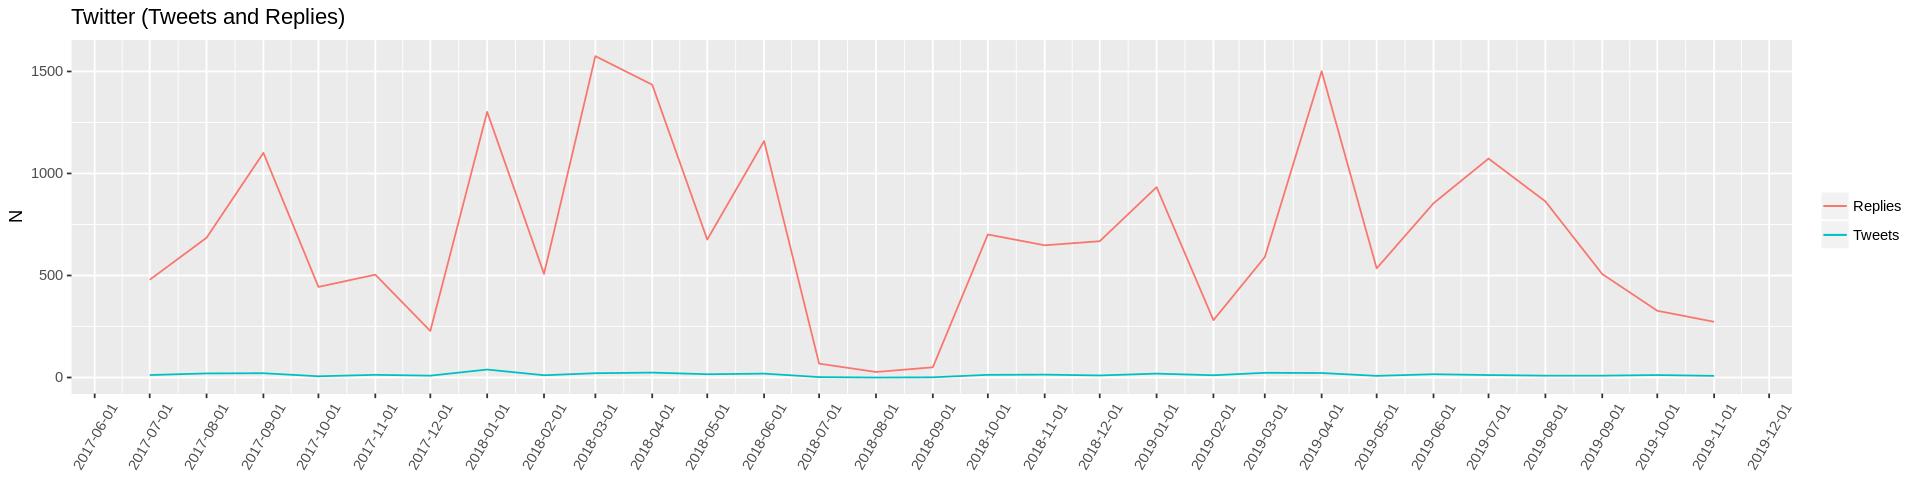

In [289]:
options(repr.plot.width=16, repr.plot.height=4)

# plotting tweets and replies
ggplot(data = merged, mapping = aes(as.Date(labels))) +
  geom_line(aes(y = values.x, color="Tweets")) +
  geom_line(aes(y = values.y, color="Replies")) +
  labs(title = "Twitter (Tweets and Replies)", y = "N") +
  theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
  scale_x_date(date_breaks = "1 month") 

# <span style="color:green">Vergleich mehrerer Politiker</span>

In [291]:
params = list(
    from_date='2017-07-01',
    to_date='2019-11-31',
    aggregate_by='month'   
)

In [292]:
politician_ids = list('996','1145','2505', '2078') #Beer: 996, Barley: 1145, Brandner: 2505, Gysi: 2078, Lindner: 636


In [293]:
tweets_by <- list()
replies_to <- list()
for (i in seq_along(politician_ids)){
    url_tweets <- paste(base,"twitter/tweets_by/politicians/", politician_ids[i], "/?", sep="")
    url_replies <- paste(base,"twitter/replies_to/politicians/", politician_ids[i], "/?", sep="")
    
    # process tweets by politician 
    tb_temp <- as.data.frame(fromJSON(content(GET(url_tweets, query=params), "text", encoding="UTF-8"), flatten = TRUE))
    tb_temp[['politician_id']] <- as.numeric(politician_ids[i]) 
    tb_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    tweets_by[[i]] <- tb_temp
    
    # process replies to 
    rt_temp  <- as.data.frame(fromJSON(content(GET(url_replies, query=params), "text", encoding="UTF-8"), flatten = TRUE))
    rt_temp[['politician_id']] <- as.numeric(politician_ids[i]) 
    rt_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    replies_to[[i]] <- rt_temp
}

In [294]:
#filter (rt_temp, politician_id == "2078")

In [295]:
# Integrate all individual dataframes per politician into single dataframes
tweets_by <- Reduce(function(x, y) rbind(x, y), tweets_by)
replies_to <- Reduce(function(x, y) rbind(x, y), replies_to)


## Tweets

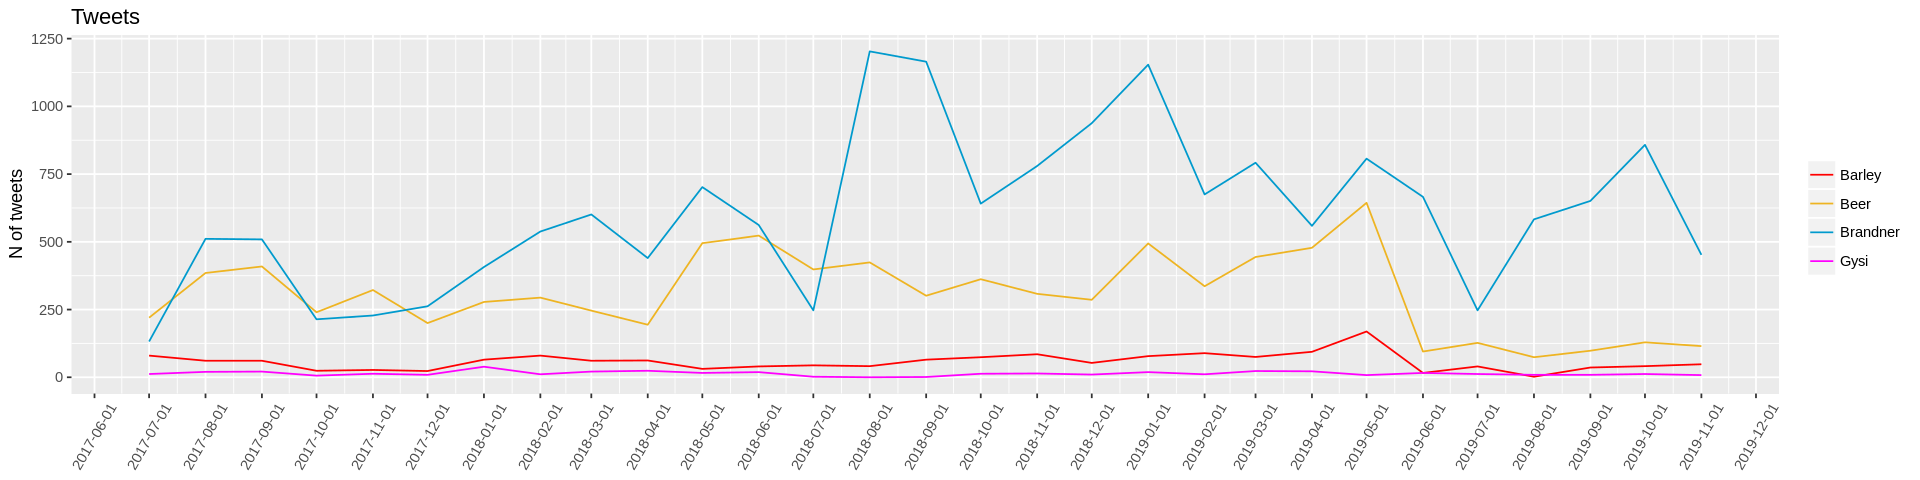

In [323]:
color_palette <- c("Barley"="red", "Beer"="goldenrod2","Gysi"="magenta1","Brandner"="deepskyblue3")
# plotting tweets 
ggplot(data=tweets_by, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets", y = "N of tweets") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

## Antworten

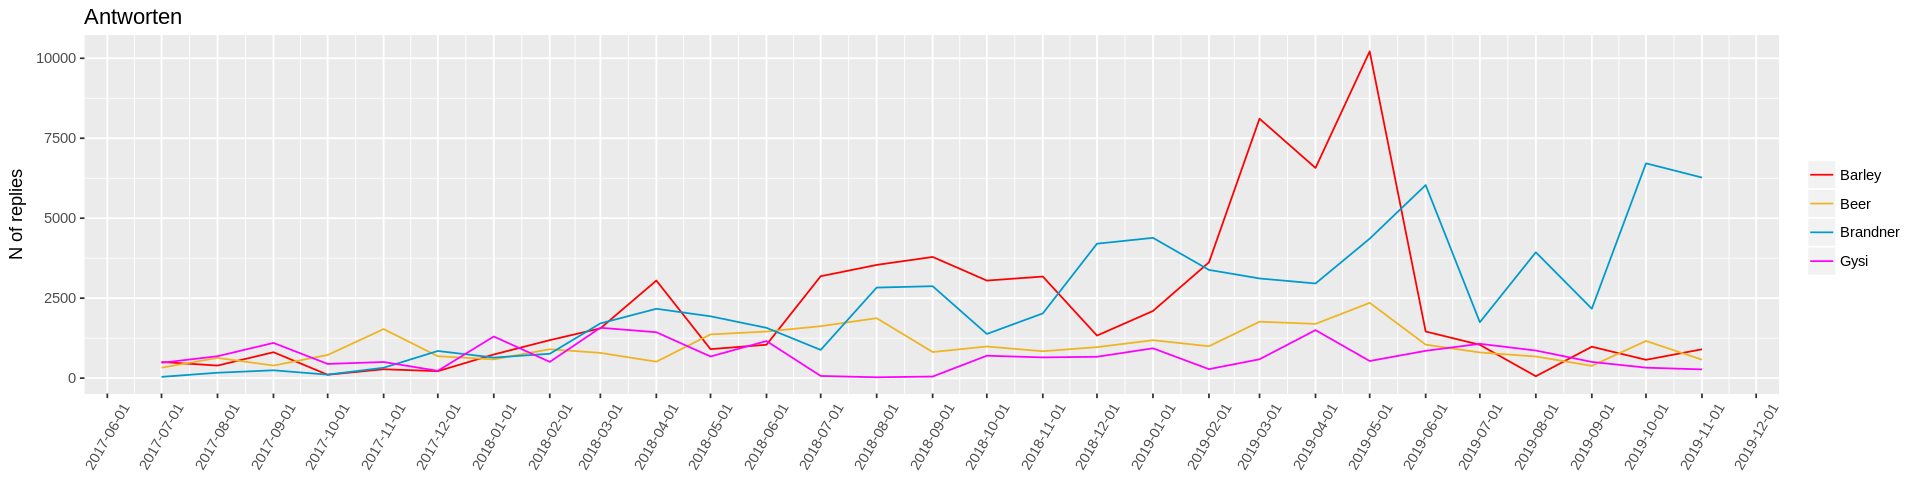

In [325]:
# plotting reponses 
ggplot(data=replies_to, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Antworten", y = "N of replies") +
    scale_color_manual(name='politician_name',values=color_palette)+
    scale_x_date(date_breaks = "1 month") 

In [300]:
#merging tweets and replies to get the ratio
all <- merge(tweets_by, replies_to, by=c('labels', 'politician_id'))

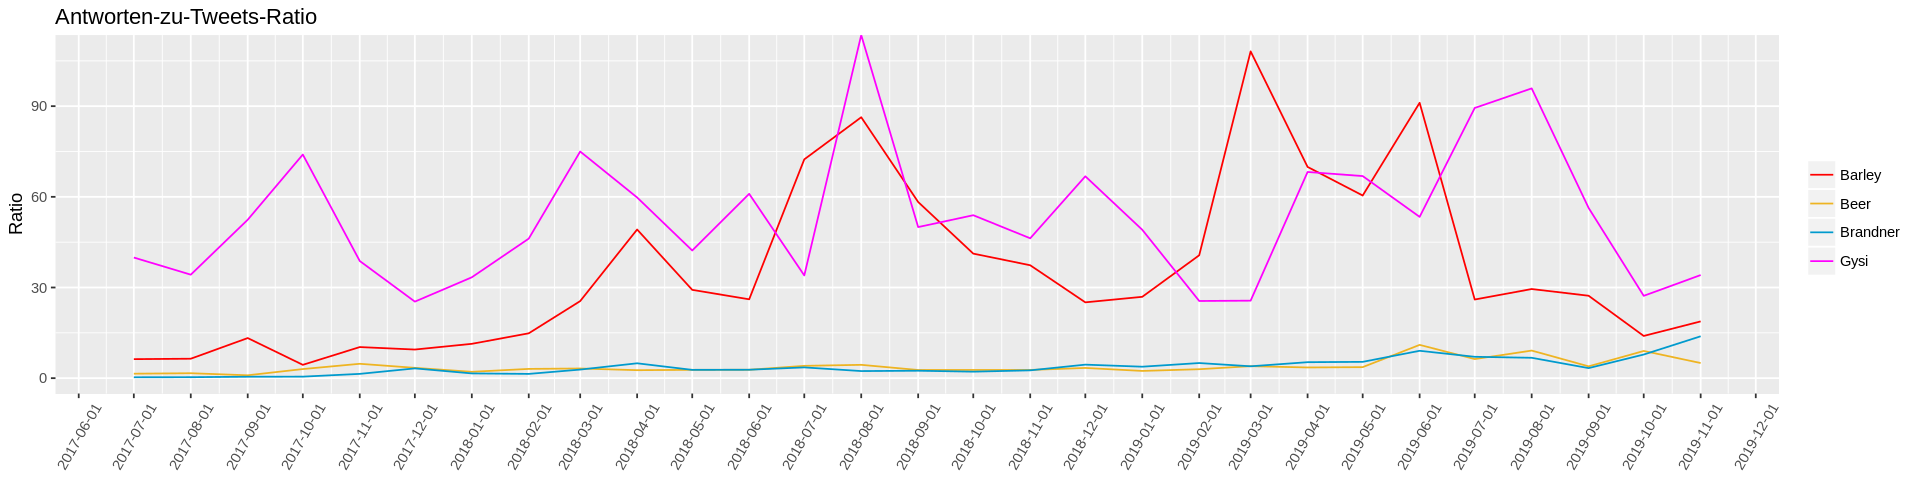

In [326]:
# plotting ratio between responses and tweets 
all <- merge(tweets_by, replies_to, by=c('labels', 'politician_id'))
ggplot(data=all, aes(x=as.Date(labels), y=values.y/values.x)) + 
    geom_line(aes(colour = factor(politician_name.x))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Antworten-zu-Tweets-Ratio", y = "Ratio") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

## Was sind das für Antworten? 
Vielleicht kann uns das "Wörterbuch des besorgten Bürgers" helfen. (Feustel et al. , http://sprachlos-blog.de/wdbb/)  
Auszug: "Abendland|Abschiebeverhinderungsindustrie|Entvölkerung|Ficki-Ficki-Fachkräfte|"Political Correctness"|prorussisch|Rapefugees", bereinigt um Begriffe, die andersgemeinte Homonyme haben.

In [303]:
wdbb <- paste(readLines("WdbB_short.txt"))

Warning message in readLines("WdbB_short.txt"):
“incomplete final line found on 'WdbB_short.txt'”


In [304]:
params = list(
    from_date='2017-07-01',
    to_date='2019-11-31',
    aggregate_by='month',
    text_contains=wdbb    
)

In [305]:
replies_to_wdbb <- list()
for (i in seq_along(politician_ids)){
    url_replies <- paste(base,"twitter/replies_to/politicians/", politician_ids[i], "/?", sep="")
    
   # process replies to 
    rt_temp  <- as.data.frame(fromJSON(content(GET(url_replies, query=params), "text", encoding="UTF-8"), flatten = TRUE))
    rt_temp[['politician_id']] <- as.numeric(politician_ids[i])
    rt_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    replies_to_wdbb[[i]] <- rt_temp
}

In [306]:
# Integrate all individual dataframes per politician into single dataframes
replies_to_wdbb <- Reduce(function(x, y) rbind(x, y), replies_to_wdbb)


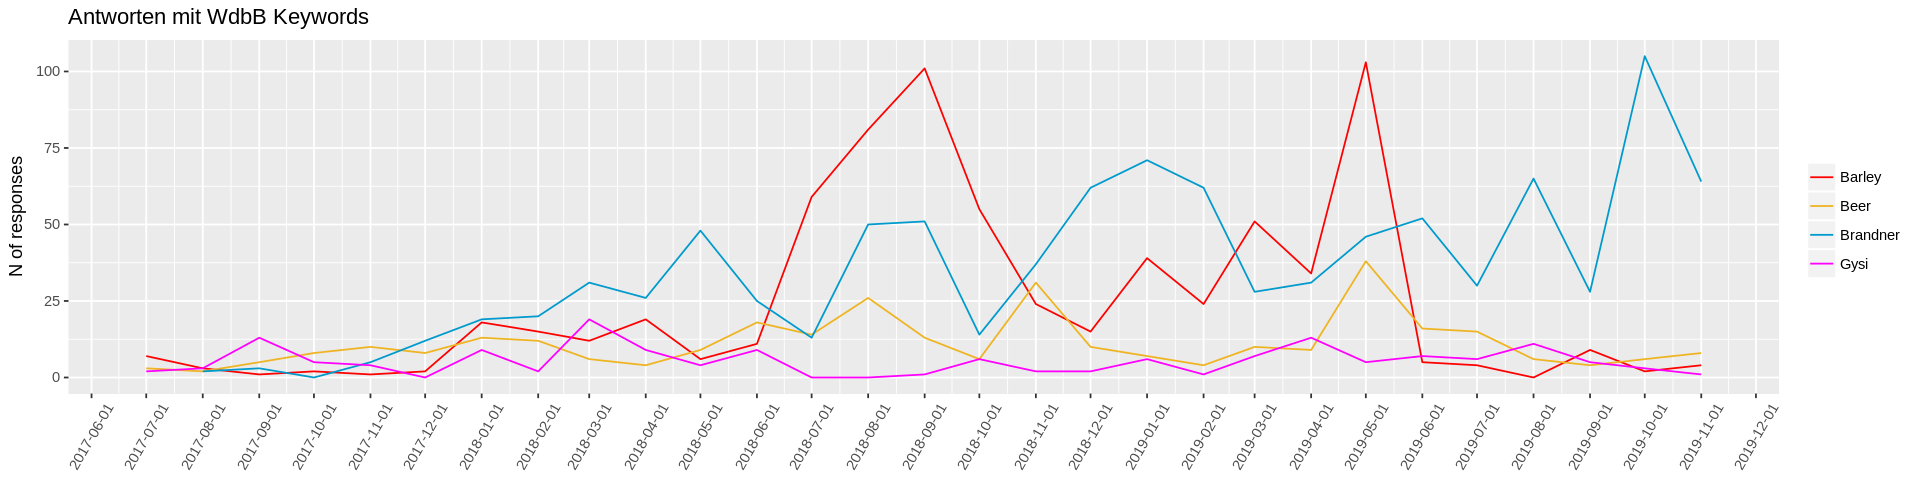

In [327]:
# plotting reponses 
ggplot(data=replies_to_wdbb, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Antworten mit WdbB Keywords", y = "N of responses") +
    scale_color_manual(values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

# Und auf Facebook? 

In [308]:
params_fb = list(
    from_date='2017-01-01',
    to_date='2018-08-31',
    aggregate_by='month'   
)

In [309]:
posts_by <- list()
comments_by <- list()
for (i in seq_along(politician_ids)){
    url_posts <- paste(base,"facebook/posts_by/politicians/", politician_ids[i], "/?", sep="")
    url_comments <- paste(base,"facebook/comments_by/politicians/", politician_ids[i], "/?", sep="")
    
    # process posts by politician 
    pb_temp <- as.data.frame(fromJSON(content(GET(url_posts, query=params_fb), "text", encoding="UTF-8"), flatten = TRUE), stringsAsFactors = FALSE)
    pb_temp[['politician_id']] <- as.numeric(politician_ids[i]) 
    pb_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    if(pb_temp[['response_type']][1] != "error") {
        posts_by[[i]] <- pb_temp
        }
    
    # process comments 
    cb_temp  <- as.data.frame(fromJSON(content(GET(url_comments, query=params_fb), "text", encoding="UTF-8"), flatten = TRUE), stringsAsFactors = FALSE)
    cb_temp[['politician_id']] <- as.numeric(politician_ids[i])  
    cb_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    if(cb_temp[['response_type']][1] != "error") {
        comments_by[[i]] <- cb_temp
        }
}

In [310]:
#filling missing data
for (i in seq_along(posts_by)) {
    empty_dates <- posts_by[[i]]$labels[!posts_by[[i]]$labels %in% comments_by[[i]]$labels]
    if (length(empty_dates)) {
        for (date in empty_dates) {
            comments_by[[i]][nrow(comments_by[[i]]) + 1,] = list("aggregation","month", as.character(date), 0, 0, 0, comments_by[[i]]$politician_id[1], comments_by[[i]]$politician_name[1])
            }
        }
    }

In [311]:
posts_by <- Reduce(function(x, y) rbind(x, y), posts_by)
comments_by <- Reduce(function(x, y) rbind(x, y), comments_by)

## Posts 

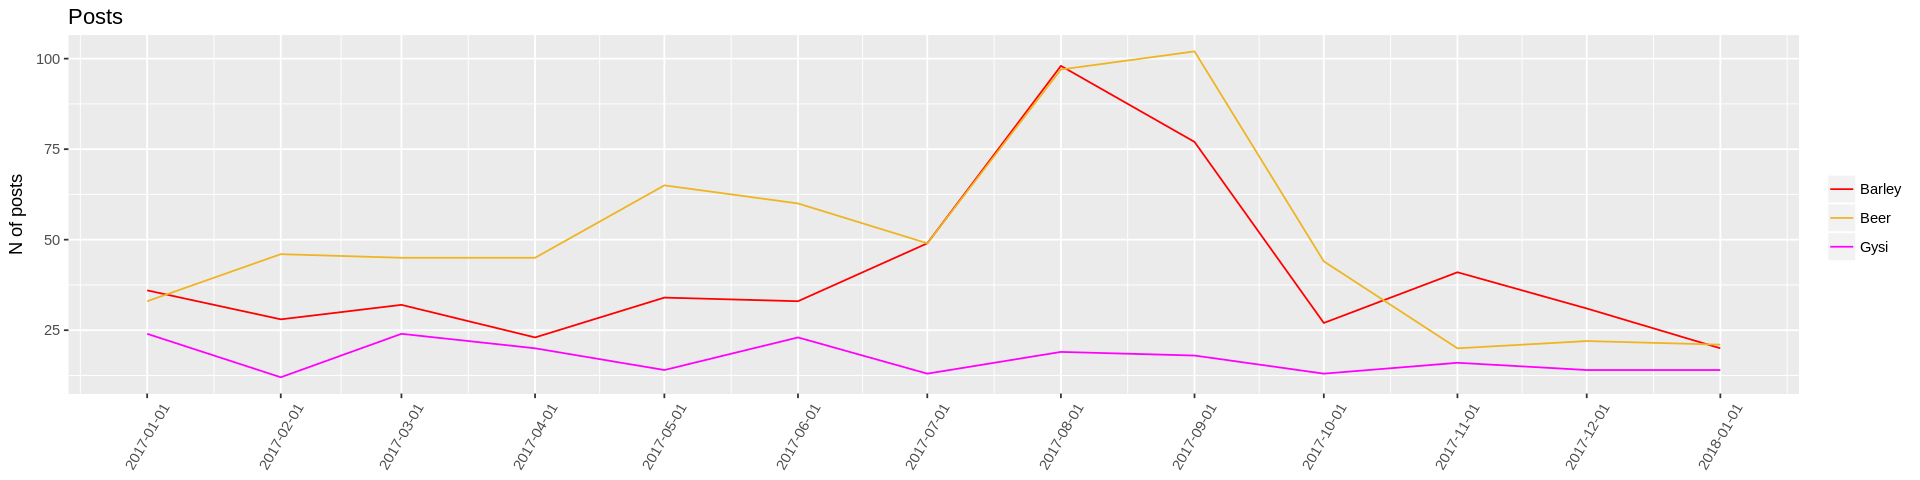

In [328]:
# plotting posts 

ggplot(data=posts_by, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Posts", y = "N of posts") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

In [329]:
#merging posts and comments together to get engagement
fb_merged <- merge(posts_by, comments_by, by=c('labels', 'politician_id'))
fb_merged['engagement'] = fb_merged['shares'] + fb_merged['reactions'] + fb_merged['values.y']

## Engagement (reactions + shares + comments)

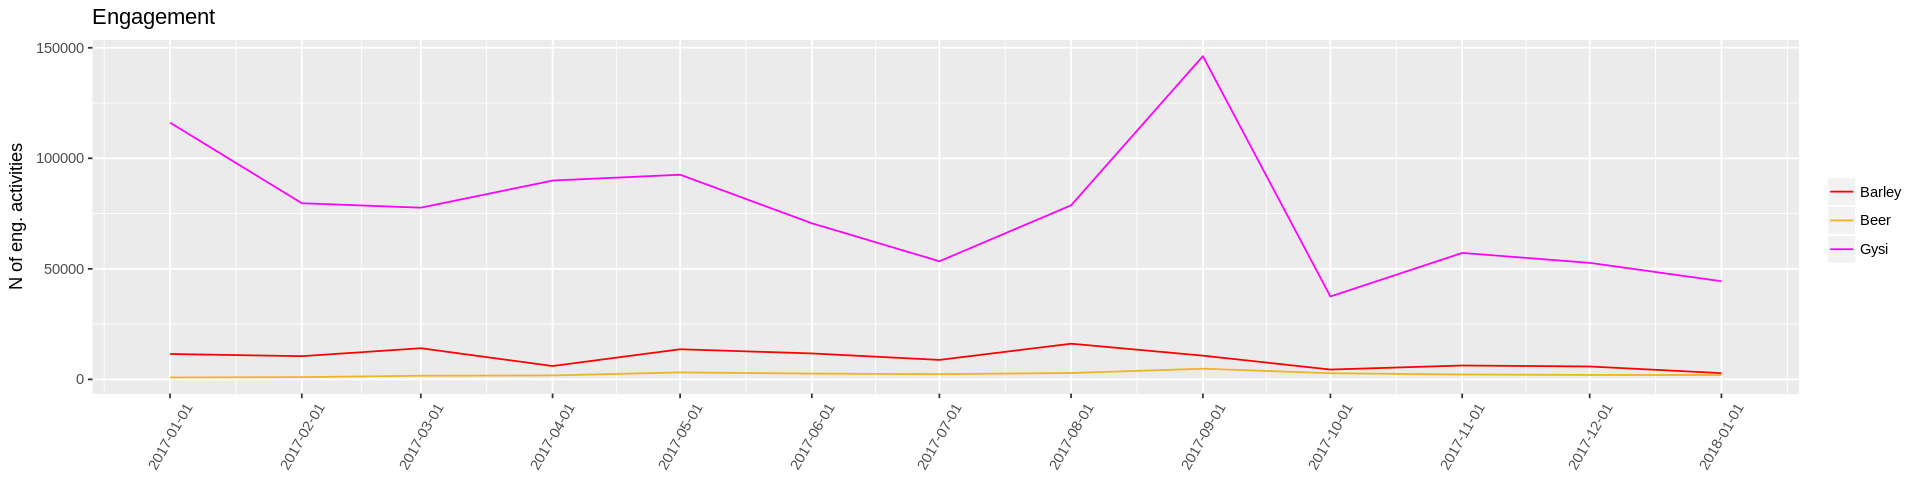

In [330]:
# plotting engagement (comments + reactions + shares) 
ggplot(data=fb_merged, aes(x=as.Date(labels), y=engagement)) + 
    geom_line(aes(colour = factor(politician_name.x))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Engagement", y = "N of eng. activities") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

## Ratio engagement-to-posts

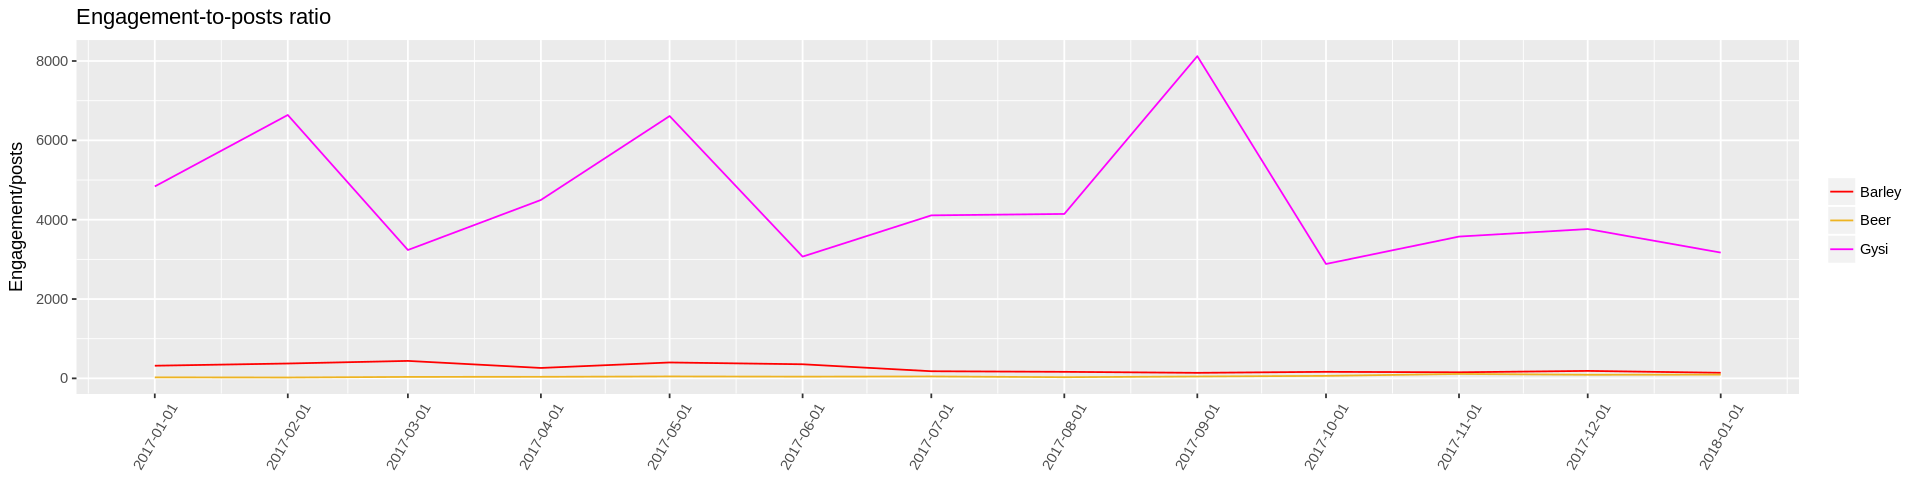

In [332]:
# plotting ratio between engagement and posts 
ggplot(data=fb_merged, aes(x=as.Date(labels), y=engagement/values.x)) + 
    geom_line(aes(colour = factor(politician_name.x))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Engagement-to-posts ratio", y = "Engagement/posts") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

# Interesse gegenüber Wikipedia-Seiten

In [261]:
views_all <- list()
library('dplyr', warn.conflicts = FALSE)

#prepare parameters
params_wp = list(
    start=params$from_date,
    end=params$to_date 
)
for (i in seq_along(politician_ids)){
    url_politician <- paste(base,"all/", politician_ids[i], "/", sep="")
    
    politician <- fromJSON(content(GET(url_politician), "text", encoding="UTF-8"), flatten = TRUE)
    # prepare the urls
    pre <- "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/de.wikipedia.org/all-access/user/"
    post <- paste("/daily/", gsub("-", "", params_wp$start),"/", gsub("-", "", params_wp$end), sep="")

    # get the data throught the Wikimedia API
    appended_views = list()
    for (wp_title in politician$wp_titles) {
        x <- tryCatch({
            view = as.data.frame(fromJSON(content(GET(
                paste(pre, URLencode(wp_title, reserved=TRUE), post, sep="")), "text", 
                encoding="UTF-8"), flatten = TRUE))
            appended_views <- append(appended_views, list(view))
        }, error = function(e) e )
    }
    views  <- dplyr::bind_rows(appended_views)

    # prepare the dates in the right format
    views$items.timestamp<-as.POSIXct(strptime(views[["items.timestamp"]], format='%Y%m%d%H'),tz = 'GMT')

    # daily, weekly or monthly aggregation of the data
    views <- summarise(group_by(views, time = cut(items.timestamp, params$aggregate_by)), items.views = sum(items.views))
                      
    #get the politician name
    views[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    views_all[[i]] <- views
                      }
views_all <- Reduce(function(x, y) rbind(x, y), views_all)

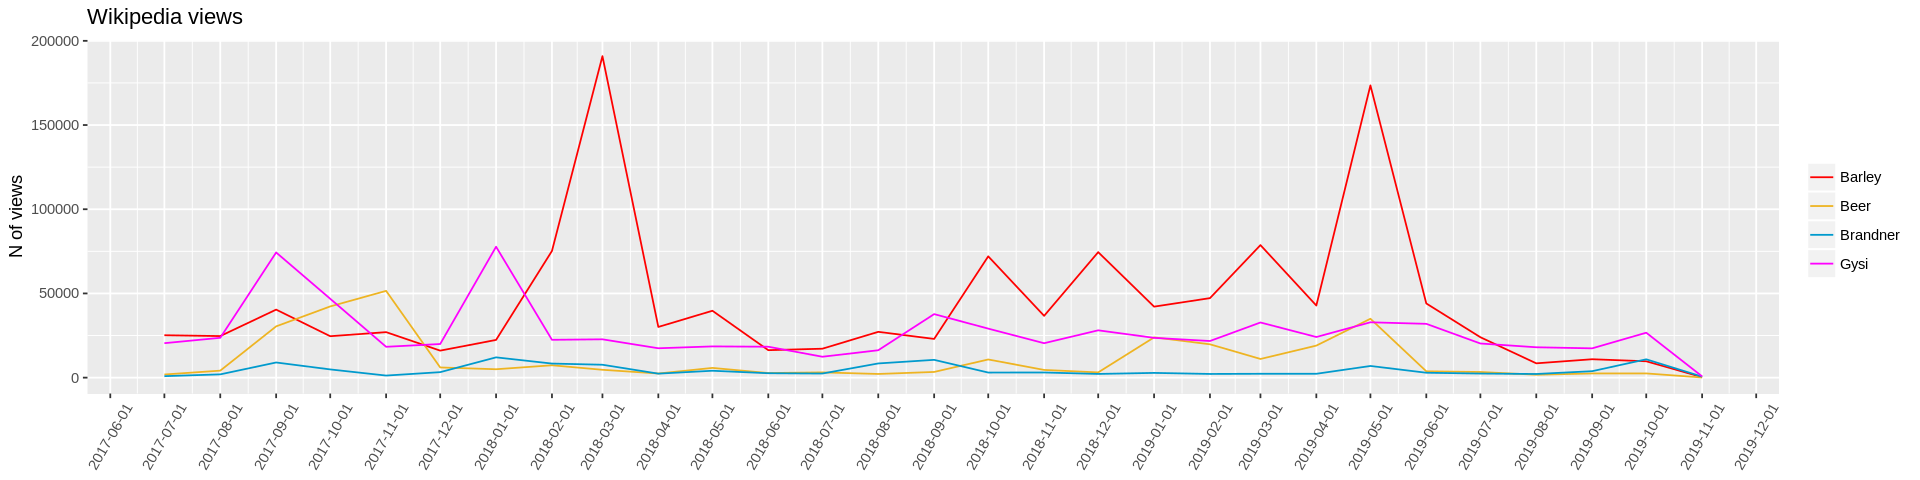

In [333]:
#plotting wikipedia views
ggplot(data=views_all, aes(x=as.Date(time), y=items.views)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Wikipedia views", y = "N of views") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 